In [1]:
from CellClass import MCImage
from CellClass import imread
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/processed/S1b_10.tif")

In [3]:
img.min(), img.max()

(0.09411765, 1.0)

In [4]:
MCIm = MCImage(img, scheme="BGR")

In [5]:
MCIm.B.min(), MCIm.B.max(), MCIm.G.min(), MCIm.G.max(), MCIm.R.min(), MCIm.R.max()

(0.11372549, 1.0, 0.09411765, 1.0, 0.28235295, 1.0)

In [6]:
MCIm.normalize()

In [7]:
MCIm.B.min(), MCIm.B.max(), MCIm.G.min(), MCIm.G.max(), MCIm.R.min(), MCIm.R.max()

(0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

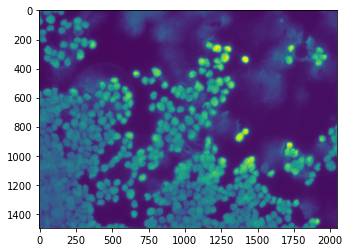

In [8]:
plt.imshow(MCIm.B)

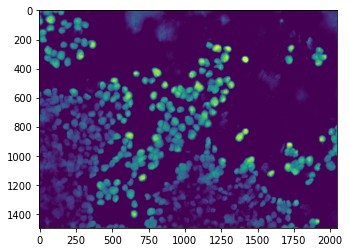

In [9]:
from skimage.morphology import reconstruction

h = 0.6
im = MCIm.B
seed = im - h
background = reconstruction(seed, im)
hdome = im - background

im = hdome 
plt.imshow(im)
plt.show() 

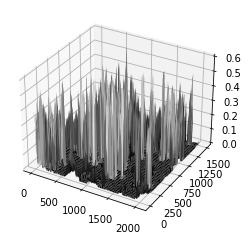

In [10]:
#%matplotlib qt

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = range(MCIm.B.shape[1])
Y = range(MCIm.B.shape[0])
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, im, cmap="gray")

plt.show()

In [11]:
from deepcell.applications import NuclearSegmentation

# Expand image dimensions to rank 4
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

# Create the application
app = NuclearSegmentation()

# create the lab
labeled_image = app.predict(im)

2022-06-02 08:56:11.689646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-02 08:56:11.689670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-02 08:56:15.069070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-02 08:56:15.069175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot ope

/home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


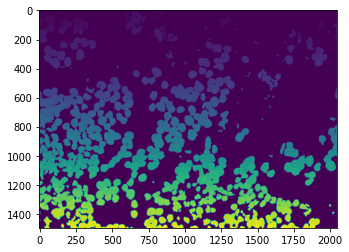

In [12]:
plt.imshow(labeled_image.squeeze())

In [13]:
from deepcell.utils.plot_utils import make_outline_overlay, create_rgb_image

rgb = np.expand_dims(np.stack((MCIm.R, MCIm.G, im.squeeze()), axis=-1),axis=0)

outline = make_outline_overlay(rgb, labeled_image)

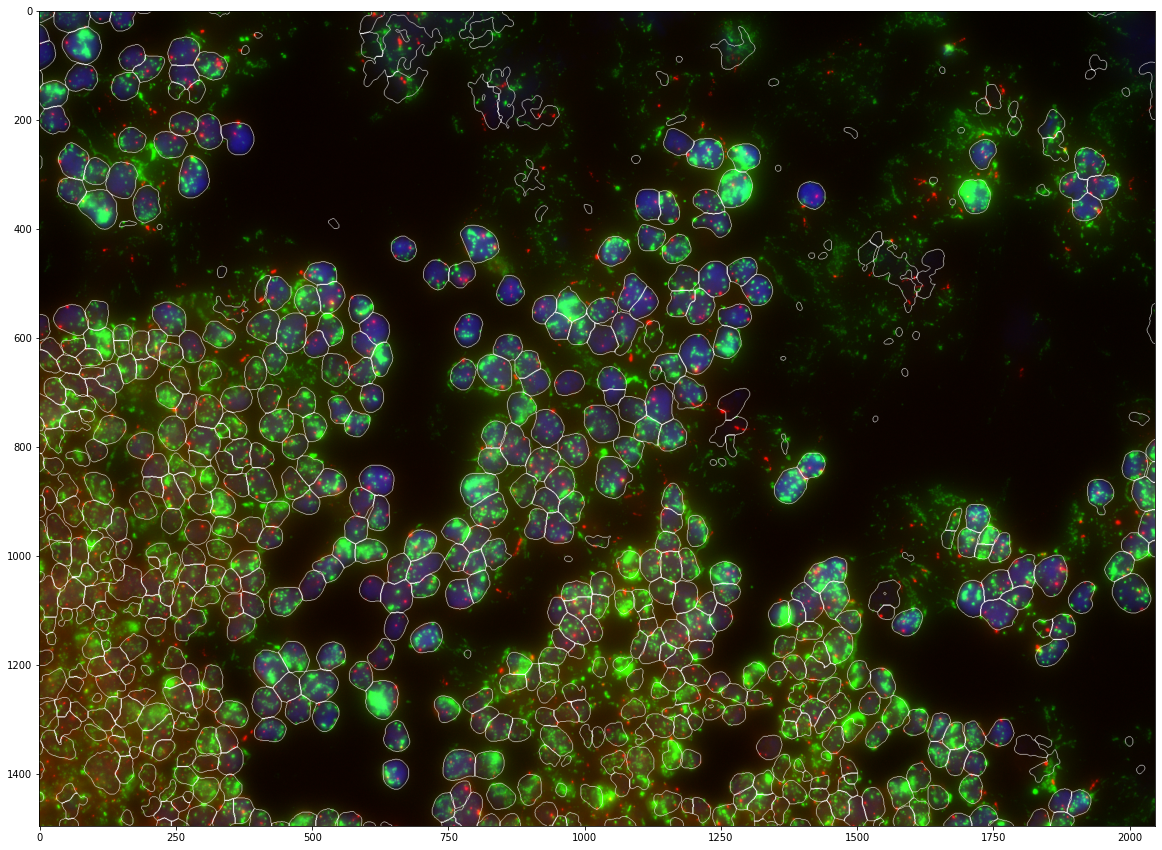

In [14]:
plt.rcParams['figure.figsize'] = 20,20
plt.imshow(outline[0])

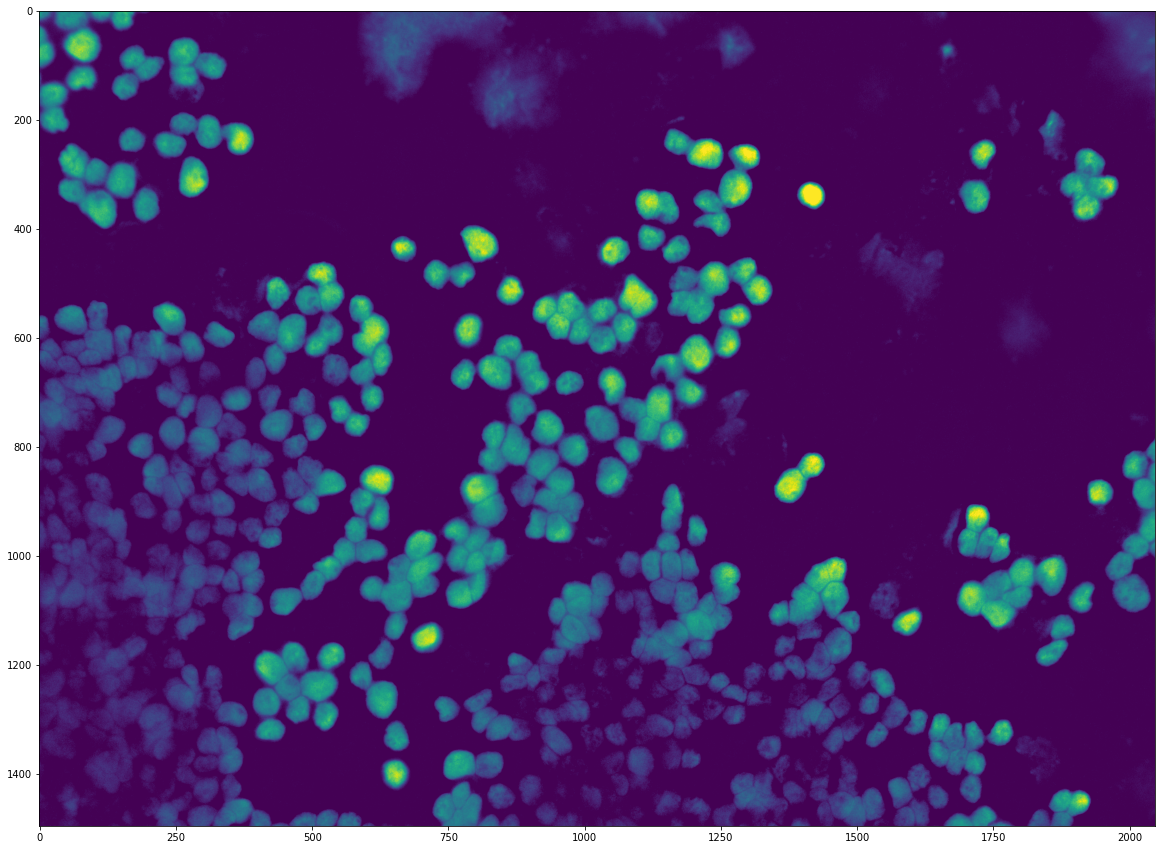

In [15]:
plt.imshow(im.squeeze())